In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to yeast interactome (various kinds of genetic and physical interactions, with particular emphasis on protein-protein interactions).

In [3]:
%matplotlib inline

# utilities
from functools import partial
import time
import os

# data analysis tools
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

# network analysis tools
import igraph as ig

# multiprocessing tools
import multiprocessing as mp


# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm

from lib import networks
from lib import qtls

%autosave 15

Autosaving every 15 seconds


**Data description:**
1. /genotypes.csv — formatted genotypes obtained from Joshua Bloom. Duplicates represent different probes taken from the same gene. Genomic coordinates and actual sequences were dropped out as unnecessary.  
In "genotypes_in_std.csv" version all the duplicates were compressed with the most frequent inheritance variant chosen for each strain.
2. /[e|p]QTLs/[averaged_expresion|genotypes].csv — self-explanatory. 
3. /[e|p]QTLs/results.csv — QTLs identified with MatrixEQTL package for R.  
"results_nodup.csv" are QTLs estimated after duplicate compression.
4. /yeast_interactome.csv — state-of-the-art database of genetic and physical interactions in yeast genome. Taken from thebiogrid.org.
5. /yeast_gene_nomenclature_mapping.csv — correspondence table between two naming conventions: standard and systematic.

**Open problems:**
1. **How should the duplicate markers be treated?**  
Original dataset contains redundant information about inheritance pattern of several parts of each marker. Meanwhile, it's obvious that interactions should be studied between pairs of **genes**, not their parts. Two solutions come to mind: either to compress the dataset with genotypes (several reads —> one gene; inheritance is defined by the most frequent pattern) or to expand the graph of interactions with as many copies of the vertex as many tags the corresponding gene has in the genotype dataset.  
Which approach is better is still not clear. Quality evaluation shows, that first approach yields 5851 pQTLs estimated (compared to the actual value of 6150), 60% of old pQTLs preserved and 2128 new pQTLs found (~38%), while the second one yields 13701 pQTls estimated (compared to the actual value of 24681) only 49% of old pQTLs are preserved and 2128 new pQTLs found (~15%). All of the calculations were carried out with respect to the FDR threshold of 5%.
2. **Which marker-gene pairs should should be tested for linkage?**  
At the moment (08.04.18), each gene G is tested for linkage with:  
	- eQTLs linked to G
	- eQTLs linked to genes interacting with G
	- genes interacting with G

In [27]:
random.seed(int(time.time()))
# 112 segregants genotyped by inherited marker variants
full_genotypes_df = pd.read_table("./data/fixed_genotypes.csv")
# full_genotypes_df = pd.read_table("./data/genotypes.csv")

''' Where possible, gene names were converted from systematic to standard notation '''
# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs/averaged_expression.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs/fixed_genotypes.csv")
eQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)
# eQTLs_genotypes_df = pd.read_table("./data/eQTLs/genotypes.csv")
# eQTLs_genotypes_df = pd.read_table("./data/eQTLs/genotypes_in_std.csv")
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs/averaged_expression.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs/fixed_genotypes.csv")
pQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)
# pQTLs_genotypes_df = pd.read_table("./data/pQTLs/genotypes.csv")
# pQTLs_genotypes_df = pd.read_table("./data/pQTLs/genotypes_in_std.csv")

# pandas DataFrame —> numpy matrix = 2x speedup
pQTLs_expression_mx = \
    pQTLs_expression_df.as_matrix(
        columns=pQTLs_expression_df.columns[1:]
    )
pQTLs_genotypes_mx = \
    pQTLs_genotypes_df.as_matrix(
        columns=pQTLs_genotypes_df.columns[1:]
    )

# Estimated QTLs
eQTLs_df = pd.read_table("./data/eQTLs/results_nodup.csv")
# eQTLs_df = pd.read_table("./data/eQTLs/results.csv")
eQTLs_df = eQTLs_df[eQTLs_df["q.value"] <= 0.05]
pQTLs_df = pd.read_table("./data/pQTLs/results_nodup.csv")
# pQTLs_df = pd.read_table("./data/pQTLs/results.csv")
pQTLs_df = pQTLs_df[pQTLs_df["q.value"] <= 0.05]


# Physical and genetic interactions taken from BioGrid project
full_interactome_df = pd.read_table("./data/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year' <= 2011]]
genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association",
    "colocalization",   
    "direct interaction",
    "physical association"
]
interaction_categories = genetic_interaction_categories + physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)
genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

physical_interactions_graph = \
    networks.assemble_graph_of_interactions(
        physical_interactions_df[["Interactor A", "Interactor B"]].values
    )

genetic_interactions_graph = \
    networks.assemble_graph_of_interactions(
        genetic_interactions_df[["Interactor A", "Interactor B"]].values
    )


# Genetic nomenclature and mappings between different naming conventions
gene_nomenclature_df = pd.read_table("./data/yeast_gene_nomenclature_mapping.csv")
gene_nomenclature_df.drop_duplicates("Systematic name", inplace=True)
std_to_sys = dict(zip(
    gene_nomenclature_df["Standard name"].values, 
    gene_nomenclature_df["Systematic name"].values
))
sys_to_std = {v: k for k, v in std_to_sys.items()}


In [6]:
# actual_markers = set(map(lambda s: s.split('_')[0], full_genotypes_df.iloc[:, 0]))
# marker_tags = dict((marker_name, []) for marker_name in actual_markers)
# for marker_name in full_genotypes_df.iloc[:, 0]:
#     actual_name, probe_tag = marker_name.split('_')
#     marker_tags[actual_name].append(probe_tag)

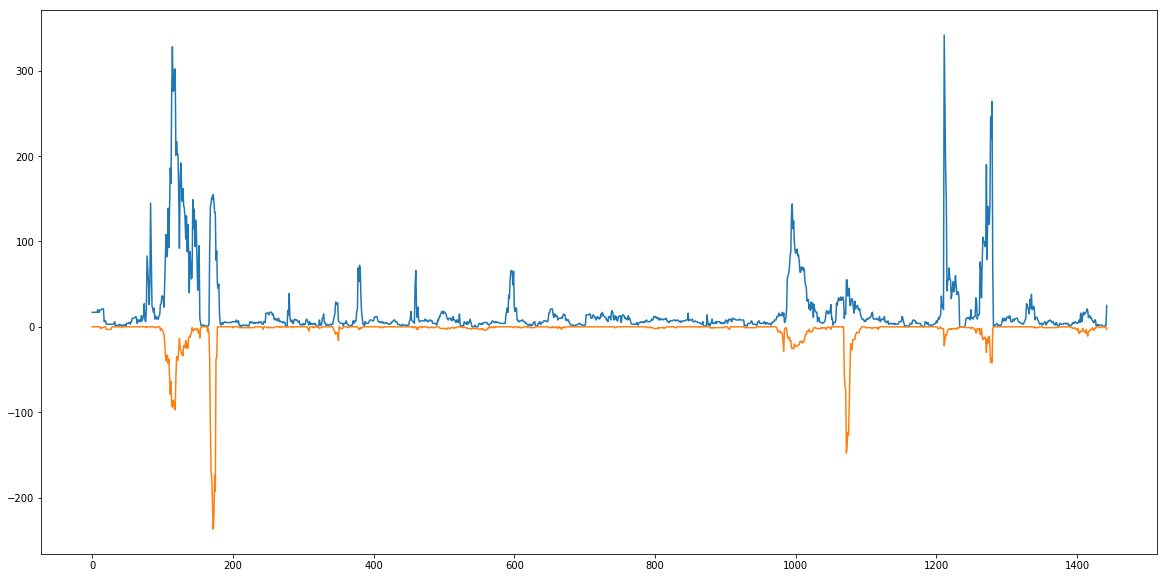

In [5]:
_, eQTL_y = qtls.map_linkages_to_genome_location(eQTLs_df, full_genotypes_df)
_, pQTL_y = qtls.map_linkages_to_genome_location(pQTLs_df, full_genotypes_df)

plt.figure(figsize=(20, 10))
plt.plot(eQTL_y)
plt.plot([-y for y in pQTL_y])
plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png")

In [7]:
# Returns a list of genes connected to gene_name in interactions_graph
# where "connected" is interpreted as "reachable in bfs_depth steps".
def convert_to_std(gene_name):
    try:
        result = sys_to_std[gene_name]
    except KeyError:
        result = gene_name
    return result


def convert_to_sys(gene_name):
    try:
        result = std_to_sys[gene_name]
    except KeyError:
        result = gene_name
    return result


# def convert_to_tagged_format(gene_name):
#     try:
#         sys_name = std_to_sys[gene_name]
#         tag_list = marker_tags[sys_name]
#         return set([ sys_name + "_" + str(tag) for tag in tag_list ])
#     except KeyError:
#         return {gene_name}

    
def get_interacting_genes(gene_name, interactions_graph, bfs_depth=1):
    ''' ЗДЕСЬ НЕ НУЖНО ПЕРЕВОДИТЬ НАЗВАНИЯ В СИСТЕМАТИЧЕСКИЕ '''
    ''' НО НУЖНО ПОМНИТЬ, ЧТО ЗДЕСЬ ЭТО НЕ ДЕЛАЕТСЯ '''
    try: 
        return set(interactions_graph.vs[
                       interactions_graph.neighborhood(gene_name, order=bfs_depth)
                   ]["name"])
    except ValueError:
        return set()

    
def get_linked_markers(gene_name, QTL_df):
    return set(QTL_df[QTL_df["gene"] == gene_name]["SNP"].values)

# Is not used. Why?
def get_linked_genes(marker_name, QTL_df):
    return set(QTL_df[QTL_df["SNP"] == marker_name]["gene"].values)


def get_linked_to_adjacent(gene_name):
    interacting_genes = set(gene_name) \
                        | get_interacting_genes(gene_name, physical_interactions_graph) \
                        | get_interacting_genes(gene_name, genetic_interactions_graph)
    # linked = {"gCL01", "NML013W", "NML011W", "YCL026C", "NBR034W" "NBR035W", "gML01", "NBR031C",
    #             "gBR08", "NCR015C", "gBR07", "gOL02", "gCR02", "YBR162W", "NBR041W", "NBR038W",
    #             "NML009C", "NNL035W", "NLR116W", "NBR043C", "NLR118C", "NLR121W", "NOL019C", "NOL020W",
    #             "gLR07", "NBR044W", "gNL07"}
    linked = set()
    for neighbor in interacting_genes:
        linked |= get_linked_markers(neighbor, eQTLs_df) 
        if neighbor != gene_name:
            linked |= set(neighbor)
        #     linked |= set(convert_to_sys(neighbor))
    return linked 
        

In [66]:
similarity_hist = []
possibly_common = 0
for gene_name in set(pQTLs_df["gene"].values):
    linked = get_linked_to_adjacent(gene_name) 
    # linked = set()
    # interacting = get_interacting_genes(gene_name, physical_interactions_graph) \
    #             | get_interacting_genes(gene_name, genetic_interactions_graph)
    interacting = set()
    pQTLs = get_linked_markers(gene_name, pQTLs_df)
    intersection_size = len((interacting | linked) & pQTLs)
    possibly_common += intersection_size
    similarity_hist.append(float(intersection_size) / len(pQTLs))
print(possibly_common, possibly_common / pQTLs_df.shape[0])
plt.hist(similarity_hist)

In [ ]:
valid_markers = set(pQTLs_genotypes_df["SNP"].values)

def get_possible_linkages(gene_name):
    linked = get_linked_to_adjacent(gene_name)
    interacting_in_std =  get_interacting_genes(gene_name, physical_interactions_graph) \
                        | get_interacting_genes(gene_name, genetic_interactions_graph)
    ''' !!! ЗДЕСЬ НУЖНО ПЕРЕВОДИТЬ НАЗВАНИЯ В СИСТЕМАТИЧЕСКИЕ !!! '''
    interacting = interacting_in_std
    # interacting = set()
    # for interacting_gene_name in interacting_in_std:
    #     interacting |= convert_to_tagged_format(interacting_gene_name)
    return [(marker, gene_name) for marker in (linked | interacting) & valid_markers]
    
pool = mp.Pool(8)
results = pool.map(get_possible_linkages, pQTLs_expression_df["gene"].values)
possible_linkages = sum(results, [])
pool.close()
pool.join()

In [ ]:
def calculate_pvalue(candidate_linkage):
    marker_name, gene_name = candidate_linkage
    genotype_rowmask = pQTLs_genotypes_df["SNP"] == marker_name
    genotype_row = pQTLs_genotypes_mx[genotype_rowmask]
    expression_rowmask = pQTLs_expression_df["gene"] == gene_name
    expression_row = pQTLs_expression_mx[expression_rowmask]
    from_BY = expression_row[genotype_row == 0]
    from_RM = expression_row[genotype_row == 2]
    _, p_value = stats.mannwhitneyu(from_BY, from_RM, alternative="two-sided")
    return p_value

pool = mp.Pool(8)
p_values = pool.map(calculate_pvalue, possible_linkages)
pool.close()
pool.join()


In [33]:
pd.DataFrame(p_values, columns=["pvalue"]).to_csv("./data/pvalues.csv", sep='\t', index=False)

In [36]:
# Call R script to calculate q-values instead, for consistency.
# What "alpha" means? Cut-off threshold?

# adjusted_results = multipletests(p_values, method="fdr_bh", alpha=0.05)
# reject, q_values = adjusted_results[0], adjusted_results[1]
q_values = pd.read_table("./data/q-values.csv").values
reject = q_values <= 0.05

new_pQTLs_list = []

for i in range(len(possible_linkages)):
    marker_name, gene_name = possible_linkages[i]
    new_pQTLs_list.append((marker_name, gene_name, p_values[i], q_values[i], reject[i]))

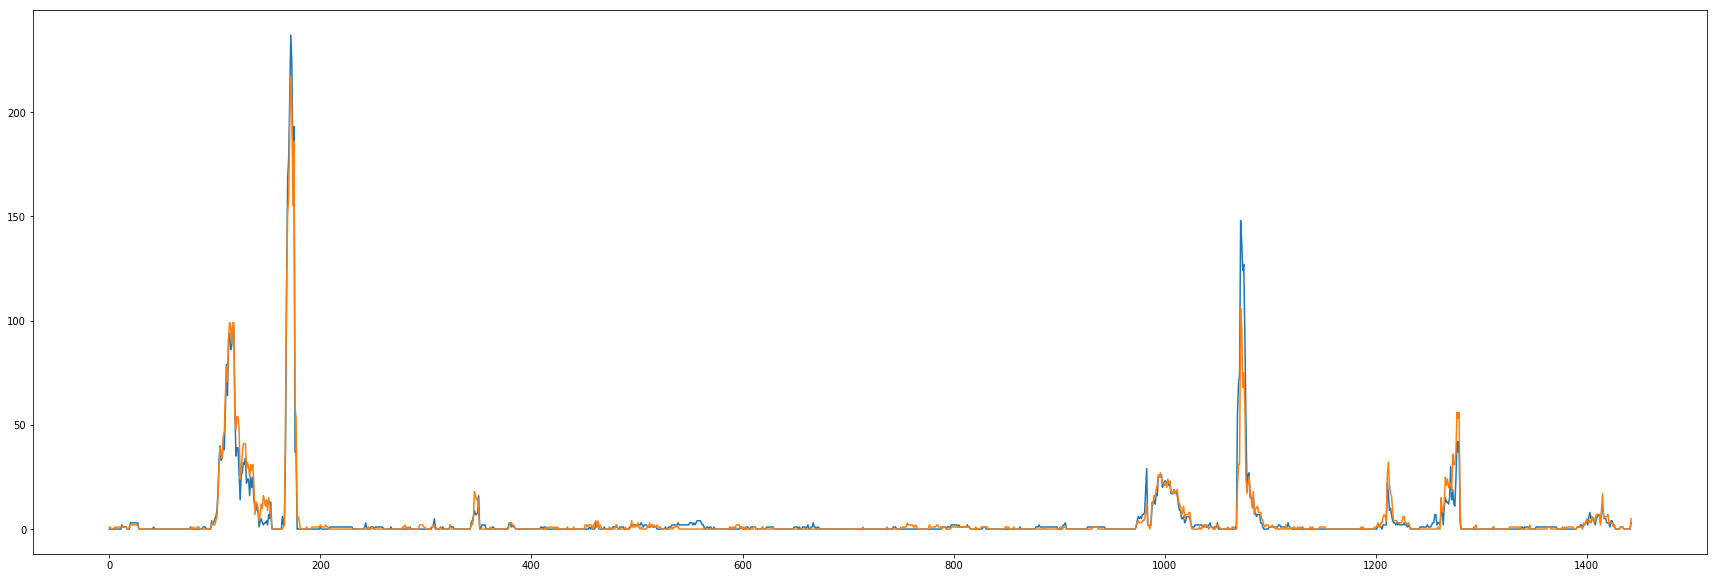

In [37]:
# Original and new results comparison via plots
new_pQTLs_df = pd.DataFrame(new_pQTLs_list, columns=["SNP", "gene", "pvalue", "qvalue", "reject"])
new_pQTLs_df = new_pQTLs_df[new_pQTLs_df["reject"] == True] 
new_pQTLs_df.to_csv("./data/pQTLs/new_results.csv", sep='\t', index=False, na_rep='NA')

old_pQTL_x, old_pQTL_y = qtls.map_linkages_to_genome_location(pQTLs_df, full_genotypes_df)
new_pQTL_x, new_pQTL_y = qtls.map_linkages_to_genome_location(new_pQTLs_df, full_genotypes_df)

plt.figure(figsize=(30, 10))
# plt.xticks(range(len(old_pQTL_x)), [s if old_pQTL_y[i] > 300 else "" for i, s in enumerate(old_pQTL_x)], rotation='vertical', size=4)
plt.plot(old_pQTL_y)
plt.plot(new_pQTL_y)
# plt.plot([-y for y in eQTL_y])
plt.savefig("./img/linkages/pQTLs_old_and_new.png", format="png", dpi=300) 

In [ ]:
new_pQTLs_df = pd.read_table("./data/pQTLs/new_results.csv", sep='\t')
new_pQTLs_df = new_pQTLs_df[new_pQTLs_df["reject"] == "[ True]"] 

# approach quality evaluation:
# similarity = []
# for threshold in range(10, 200, 10):
num_linked_to_gene = { gene_name: 0 for gene_name in pQTLs_df["gene"].values }
num_linked_to_marker = { marker_name: 0 for marker_name in pQTLs_df["SNP"].values }
for marker_name, gene_name in pQTLs_df[["SNP", "gene"]].values:
    num_linked_to_marker[marker_name] += 1
    num_linked_to_gene[gene_name] += 1

# old_pQTL_linkage_pairs = set()
# for marker_name, gene_name in pQTLs_df[["SNP", "gene"]].values:
#     if num_linked_to[gene_name] < threshold:
#         old_pQTL_linkage_pairs.update([(marker_name, gene_name)])

old_pQTL_linkage_pairs = set(
    (marker_name, gene_name) 
    for marker_name, gene_name in pQTLs_df[["SNP", "gene"]].values
)

common = 0
for marker_name, gene_name in new_pQTLs_df[["SNP", "gene"]].values:
    linkage_pair = (marker_name, gene_name)
    common += linkage_pair in old_pQTL_linkage_pairs
    
print(
    "Common linkages: {}, {}%\n"
    "Old linkages, total: {}\n"
    "New linkages, total: {}\n"
    "New linkages found: {}"
    .format(common, 100 * common / pQTLs_df.shape[0], 
            pQTLs_df.shape[0], 
            new_pQTLs_df.shape[0], 
            new_pQTLs_df.shape[0] - common)
)
# similarity.append(common / pQTLs_df.shape[0])
# plt.plot(range(10, 200, 10), similarity)


Common linkages: 3679, 59.55001618646811%
Old linkages, total: 6178
New linkages, total: 6199
New linkages found: 2520


In [113]:
pd.DataFrame(p_values, columns=["pvalue"]).to_csv("./data/pvalues.csv", sep='\t', index=False)

In [137]:
len([p for p in sorted(num_linked_to_marker.items(), key=lambda p: -p[1]) if p[1] >= 50])

26

In [273]:
def strain_to_list(item):
    l = item.split('_')
    return [int(l[0]), int(l[1]), ord(l[2])]

initial_genotypes_df = pd.read_table("./data/josh_formatted_genotypes.csv")
prev_snp_name = None
new_rows_list = []
current_rowdict = [[0, 0, 0] for _ in range(initial_genotypes_df.shape[1] - 1)] 
for row in initial_genotypes_df.itertuples():
    snp_name = row[1].split('_')[0]
    if snp_name != prev_snp_name:
        if prev_snp_name is not None:
            new_row = [prev_snp_name]
            for d in current_rowdict:
                new_row.append(max([0, 1, 2], key=lambda x: d[x]))
            new_rows_list.append(new_row)
        current_rowdict = [[0, 0, 0] for _ in range(initial_genotypes_df.shape[1] - 1)] 
    for i, val in enumerate(row[2:]):
        current_rowdict[i][val] += 1
    prev_snp_name = snp_name
new_rows_list.append([prev_snp_name] + [max([0, 1, 2], key=lambda x: d[x]) for d in current_rowdict])
processed_rows_list = []
logical_val = {0:0, 1:2, 2:None}
for row in new_rows_list:
    processed_rows_list.append(row[:])
    for i in range(1, len(processed_rows_list[-1])):
        processed_rows_list[-1][i] = logical_val[processed_rows_list[-1][i]]
new_rows_tuples = [tuple(l) for l in processed_rows_list]
fixed_genotypes = pd.DataFrame(new_rows_tuples, columns=initial_genotypes_df.columns)
fixed_genotypes = fixed_genotypes[["SNP", "BY", "RM"] 
                                  + sorted(fixed_genotypes.columns[3:], key=strain_to_list)]
fixed_genotypes.to_csv("./data/fixed_genotypes.csv", sep='\t', index=False, na_rep='NA')

In [233]:
print(processed_rows_list[0])

['YAL069W', 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, None, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, None, None, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, None, 0, 0, 2]


In [ ]:
fixed_genotypes.drop(
    sorted(list(set(fixed_genotypes.columns[1:]) - set(eQTLs_expression_df.columns[1:])), 
           key=strain_to_list),
    axis=1
).to_csv(
    "./data/eQTLs/fixed_genotypes.csv", sep='\t', index=False, na_rep="NA"
)

fixed_genotypes.drop(
    sorted(list(set(fixed_genotypes.columns[1:]) - set(pQTLs_expression_df.columns[1:])), 
           key=strain_to_list),
    axis=1
).to_csv("./data/pQTLs/fixed_genotypes.csv", sep='\t', index=False, na_rep="NA")


2